In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.transform import resize
from skimage.filters import threshold_otsu
import cv2
from Utils import *

In [2]:
color_channels = 3
pixel_depth = 255.0
bbox_horz_exp = 1  # Pixels to expand bounding boxes by in each horizontal direction

**Preprocess images**

In [3]:
def import_bboxes(path):
    path = data_dir + path
    mat = h5py.File(path + '/digitStruct.mat', 'r')
    dig = mat['digitStruct']
    bbox = dig['bbox']
    keys = dig[bbox[0, 0]].keys()
    data = {k: [] for k in keys}
    n_samples = bbox.shape[0]
    data['n_digits'] = [dig[bbox[i, 0]]['label'][()].shape[0] for i in range(n_samples)]
    for key in keys:
        res = []
        for i in range(n_samples):
            n_digs = data['n_digits'][i]
            ds = [dig[bbox[i, 0]][key][()][j, 0] for j in range(n_digs)]
            if n_digs != 1:
                ds = [int(mat[d][()][0, 0]) for d in ds]
            else:
                ds = [int(d) for d in ds]
            data[str(key)].append(ds)
    return n_samples, data
def import_images(path, n_images):
    path = data_dir + path
    images = []
    for i in range(1, n_images + 1):
        img = (ndimage.imread(path + '/' + str(i) + '.png').astype(float) - pixel_depth / 2) / pixel_depth
        images.append(img)
        if (i + 1) % 10 == 0:
            sys_pr('\rImported image ' + str(i + 1))
    print()
    return images
def local_contrastive_norm(img):
    img = deepcopy(img)
    img += 0.5
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    float_gray = gray.astype(np.float32) / 255.0
    blur = cv2.GaussianBlur(float_gray, (0, 0), sigmaX=2, sigmaY=2)
    num = float_gray - blur
    blur = cv2.GaussianBlur(num*num, (0, 0), sigmaX=25, sigmaY=25)
    den = cv2.pow(blur, 0.5)
    gray = num / den
    cv2.normalize(gray, dst=gray, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX)
    return gray - 0.5
def extract_digits(images, bboxes, dims=(14, 29)):
    new_n = sum(bboxes['n_digits'])
    digh, digw = dims
    digw += bbox_horz_exp * 2
    res = np.ndarray(shape=(new_n, digh, digw), dtype=np.float32)
    lbls = np.ndarray(shape=(new_n), dtype=np.int32)
    x_i = 0
    for i in range(len(images)):
        for j in range(bboxes['n_digits'][i]):
            top = bboxes['top'][i][j]
            left = bboxes['left'][i][j]
            
            if bboxes['width'][i][j] == 0:
                print(i, j)
            if bboxes['height'][i][j] == 0:
                print('height', i, j)
            
            h = top + bboxes['height'][i][j]
            w = left + bboxes['width'][i][j] + bbox_horz_exp
            top = max(0, top)
            left = max(0, left - bbox_horz_exp)
            
            img = images[i][top:h, left:w, :]
#             if img.shape[1] == 0:
#                 print(img.shape, i, j, images[i].shape, top, left,bboxes['height'][i][j], bboxes['width'][i][j])
            img = resize(np.ascontiguousarray(img), (digh, digw))
            img = local_contrastive_norm(img.astype(np.float32))
        
            img_flat = img.flatten()  # Use Otsu's method to invert light-on-dark digits (works if there are fewer digit pixels)
            thresh = threshold_otsu(img_flat)
            mass_below = sum(img_flat <= thresh)
            mass_above = sum(img_flat > thresh)
            if mass_below > mass_above:
                img = 0.5 - img
            res[x_i] = img

            lbl = bboxes['label'][i][j]
            if lbl == 10:
                lbl = 0
            lbls[x_i] = lbl
            x_i += 1
        if (i + 1) % 10 == 0:
            sys_pr('\rPreprocessed image ' + str(i + 1) + '  ')
    print()
    return res, lbls

In [16]:
# n_train, train_bboxes = import_bboxes('train')
# n_test, test_bboxes = import_bboxes('test')
# save_ld((n_train, train_bboxes), "train_bboxes")
# save_ld((n_test, test_bboxes), "test_bboxes")
n_train, train_bboxes = load_ld("train_bboxes")
n_test, test_bboxes = load_ld("test_bboxes")

In [17]:
# train_images = import_images('train', n_train)
# test_images = import_images('test', n_test)
# save_ld(train_images, "train_images")
# save_ld(test_images, "test_images")
train_images = load_ld("train_images")
test_images = load_ld("test_images")

In [25]:
dig_height = np.median(np.hstack([train_bboxes['height'][i] for i in range(len(train_bboxes['label']))]))
dig_width = np.median(np.hstack([train_bboxes['width'][i] for i in range(len(train_bboxes['label']))]))
print("Average digit dimensions:", (dig_height, dig_width))
dig_height = int(round(dig_height))
dig_width = int(round(dig_width))

In [26]:
for i in range(n_train):
    for j in range(train_bboxes['n_digits'][i]):
        if train_bboxes['width'][i][j] < 3:
            print(i + 1, j, train_bboxes['width'][i][j], train_bboxes['label'][i][j], train_bboxes['left'][i][j],
                  train_bboxes['label'][i])

In [51]:
bbox_errs = [18702 - 1, 30620 - 1]
train_bboxes = {k: [train_bboxes[k][i] for i in range(len(train_bboxes['label'])) if i not in bbox_errs] for k in train_bboxes}
train_images = [train_images[i] for i in range(len(train_images)) if i not in bbox_errs]
n_train -= len(bbox_errs)
print("Removed", len(bbox_errs), "erroneous training samples")
len(train_bboxes['label']), len(train_images)

Removed 2 erroneous training samples


(33400, 33400)

In [4]:
# train_imgs, train_lbls = extract_digits(train_images, train_bboxes, dims=(dig_height, dig_width))
# test_imgs, test_lbls = extract_digits(test_images, test_bboxes, dims=(dig_height, dig_width))
# save_ld((train_imgs, train_lbls), "train_digits")
# save_ld((test_imgs, test_lbls), "test_digits")
train_imgs, train_lbls = load_ld("train_digits")
test_imgs, test_lbls = load_ld("test_digits")

**Check array shapes and plot some test images**

In [5]:
X_train, Y_train = train_imgs, train_lbls
X_test, Y_test = test_imgs, test_lbls
n_train, n_test = X_train.shape[0], X_test.shape[0]
digh, digw = X_train.shape[1], X_train.shape[2]
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((73251, 29, 16), (73251,), (26032, 29, 16), (26032,))

In [6]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):
    assert len(images) == len(cls_true) == 9
    images = deepcopy(images)
    images += 0.5
    fig, axes = plt.subplots(3, 3)
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.set_size_inches(12, 8)
    fig.subplots_adjust(hspace=hspace, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'
        ax.imshow(images[i],
                  interpolation=interpolation)
        cls_true_name = cls_true[i]
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            cbs_pred_name = cls_pred[i]
            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

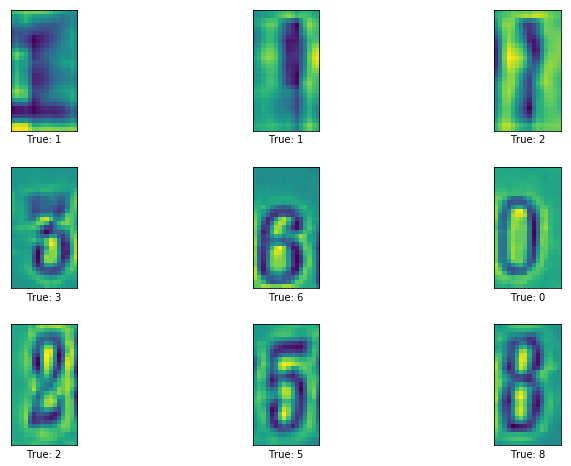

In [30]:
plot_images(images=test_imgs[900:909], cls_true=test_lbls[900:909], smooth=False)

**Shuffle training set**

In [6]:
def shuffle_data(data):
    indices = np.arange(data[0].shape[0]);
    np.random.shuffle(indices)
    return [d[indices] for d in data]
X_train, Y_train = shuffle_data([X_train, Y_train])

**Train and test Softmax regression**

In [7]:
from sklearn.pipeline import *
from sklearn.neighbors import *
from sklearn.svm import *
from sklearn.linear_model import *
from sklearn.decomposition import *
from sklearn.preprocessing import RobustScaler
from bayes_opt import BayesianOptimization

In [8]:
X_train_flat = X_train.reshape([-1, digh * digw])
X_test_flat = X_test.reshape([-1, digh * digw])
sc = RobustScaler()
X_train_flat = sc.fit_transform(X_train_flat.T).T
X_test_flat = sc.fit_transform(X_test_flat.T).T
X_train_flat.shape, X_test_flat.shape
max_val = max([X_train_flat.max(), abs(X_train_flat.min()), X_test_flat.max(), abs(X_test_flat.min())])
X_train_flat /= max_val
X_test_flat /= max_val

In [70]:
# kernels ['linear', 'poly', 'rbf']: 
# n_minitrain = 30000
n_minitrain = int(X_train.shape[0] * 0.8)
n_minitest = 10000
res = []
for C in [10**0, 10**0.333, 10**0.666, 10**1, 10**1.333, 10**1.666, 10**2]:
    dr_frac = 0.07
    dr = PCA(n_components=int(dr_frac * X_train_flat.shape[1]))
    X_train_lowdim = dr.fit_transform(X_train_flat)
    X_test_lowdim = dr.transform(X_test_flat)

    train_is = np.random.choice(X_train.shape[0], n_minitrain, replace=False)
    m = LogisticRegression(multi_class='multinomial', penalty='l2', C=C, solver='lbfgs', max_iter=3000, tol=1e-5)
    m.fit(X_train_lowdim[train_is], Y_train[train_is])
    
    test_is = np.random.choice(X_test.shape[0], n_minitest, replace=False)
    preds = m.predict(X_test_lowdim[test_is])
    res.append(sum(preds == Y_test[test_is]) / n_minitest)
    print(res[-1])

In [9]:
# n_minitrain = 30000
n_minitrain = int(X_train.shape[0] * 1.0)
n_minitest = int(X_test.shape[0] * 1.0)
def test_softmax(dr_frac, C):
    dr = PCA(n_components=int(dr_frac * X_train_flat.shape[1]))
    X_train_lowdim = dr.fit_transform(X_train_flat)
    X_test_lowdim = dr.transform(X_test_flat)

    train_is = np.random.choice(X_train.shape[0], n_minitrain, replace=False)
    m = LogisticRegression(multi_class='multinomial', penalty='l2', C=10**C, solver='lbfgs', max_iter=3000, tol=1e-5)
    m.fit(X_train_lowdim[train_is], Y_train[train_is])

    test_is = np.random.choice(X_test.shape[0], n_minitest, replace=False)
    preds = m.predict(X_test_lowdim[test_is])
    return sum(preds == Y_test[test_is]) / n_minitest

In [10]:
# Bounded region of parameter space
optimizer = BayesianOptimization(f=test_softmax, pbounds={'dr_frac': (0.05, 1.0), 'C': (-2, 3)})
optimizer.maximize(init_points=15, n_iter=100)

|   iter    |  target   |     C     |  dr_frac  |
-------------------------------------------------
|  1        |  0.607    |  2.337    |  0.2823   |
|  2        |  0.5948   | -0.08977  |  0.6203   |
|  3        |  0.6093   |  2.162    |  0.7685   |
|  4        |  0.5952   |  1.212    |  0.1512   |
|  5        |  0.3348   | -1.98     |  0.755    |
|  6        |  0.5224   | -1.142    |  0.433    |
|  7        |  0.6087   |  2.086    |  0.9365   |
|  8        |  0.6094   |  1.964    |  0.5105   |
|  9        |  0.5922   | -0.1332   |  0.2157   |
|  10       |  0.4841   | -1.381    |  0.9518   |
|  11       |  0.6066   |  0.8615   |  0.3087   |
|  12       |  0.588    | -0.3072   |  0.7842   |
|  13       |  0.4605   | -1.498    |  0.3269   |
|  14       |  0.5136   | -1.206    |  0.5182   |
|  15       |  0.6055   |  0.4476   |  0.4698   |
|  16       |  0.5351   |  3.0      |  0.05     |
|  17       |  0.609    |  0.9599   |  1.0      |


c:\python36\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


|  18       |  0.6069   |  3.0      |  1.0      |
|  19       |  0.6077   |  2.617    |  1.0      |
|  20       |  0.6092   |  1.276    |  0.7401   |
|  21       |  0.6097   |  1.519    |  0.9995   |
|  22       |  0.6092   |  2.503    |  0.617    |
|  23       |  0.6054   |  0.4261   |  0.9998   |
|  24       |  0.6088   |  0.8205   |  0.6905   |
|  25       |  0.6093   |  2.237    |  0.5285   |
|  26       |  0.5336   |  0.4931   |  0.05     |
|  27       |  0.5345   |  1.936    |  0.05     |
|  28       |  0.6094   |  1.33     |  0.428    |
|  29       |  0.6093   |  3.0      |  0.6123   |
|  30       |  0.5194   | -0.5586   |  0.05     |
|  31       |  0.5674   | -0.691    |  1.0      |
|  32       |  0.6105   |  2.711    |  0.3817   |
|  33       |  0.6091   |  1.737    |  0.7576   |
|  34       |  0.6088   |  1.066    |  0.4497   |
|  35       |  0.6086   |  2.835    |  0.777    |
|  36       |  0.584    | -0.4068   |  0.4608   |
|  37       |  0.5968   | -0.001143 |  1.0      |


KeyboardInterrupt: 

In [22]:
# # Get balanced classes (doesn't help)
# idx = []
# for digit in range(10):
#     idx.append([i for i in range(len(X_train_flat)) if Y_train[i] == digit])
# min_size = min([len(d) for d in idx])
# idx = [d[:min_size] for d in idx]
# idx = sum(idx, [])
# X_balanced = X_train_flat[idx]
# Y_balanced = Y_train[idx]
# X_balanced.shape, len(X_balanced) / len(X_train_flat)

((46580, 464), 0.6358957556893421)

In [24]:
n_minitrain = int(X_balanced.shape[0] * 1.0)
n_minitest = int(X_test.shape[0] * 1.0)
dr_frac = 0.4024
dr = PCA(n_components=int(dr_frac * X_train_flat.shape[1]))
X_train_lowdim = dr.fit_transform(X_balanced)
X_test_lowdim = dr.transform(X_test_flat)

train_is = np.random.choice(X_balanced.shape[0], n_minitrain, replace=False)
C = 2.505
m = LogisticRegression(multi_class='multinomial', penalty='l2', C=C, solver='lbfgs', max_iter=3000, tol=1e-5)
m.fit(X_train_lowdim[train_is], Y_balanced[train_is])

test_is = np.random.choice(X_test.shape[0], n_minitest, replace=False)
preds = m.predict(X_test_lowdim[test_is])
sum(preds == Y_test[test_is]) / n_minitest

0.6034880147510756

In [26]:
y_test = Y_test[test_is]

In [17]:
save_ld((y_test, preds), "sfr_output")

Normalized confusion matrix
[[0.62 0.06 0.02 0.03 0.05 0.03 0.06 0.03 0.05 0.06]
 [0.03 0.68 0.03 0.07 0.04 0.02 0.03 0.06 0.02 0.03]
 [0.02 0.1  0.58 0.03 0.04 0.02 0.03 0.1  0.04 0.03]
 [0.04 0.12 0.04 0.55 0.03 0.06 0.02 0.05 0.04 0.06]
 [0.02 0.08 0.02 0.03 0.68 0.02 0.04 0.01 0.02 0.07]
 [0.04 0.08 0.02 0.07 0.04 0.58 0.07 0.02 0.04 0.05]
 [0.09 0.05 0.03 0.03 0.1  0.05 0.56 0.03 0.04 0.03]
 [0.02 0.1  0.06 0.04 0.01 0.02 0.02 0.68 0.02 0.02]
 [0.07 0.07 0.04 0.05 0.07 0.03 0.11 0.03 0.42 0.11]
 [0.09 0.07 0.03 0.03 0.05 0.04 0.03 0.03 0.06 0.58]]


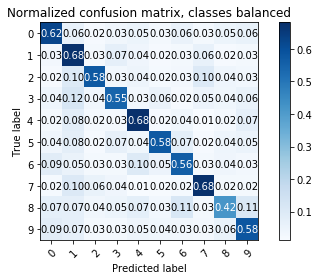

In [28]:
from sklearn.metrics import *
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
plot_confusion_matrix(y_test, preds, classes=np.arange(10), normalize=True,
                      title='Normalized confusion matrix, classes balanced')
plt.show()

Normalized confusion matrix
[[0.59 0.13 0.04 0.04 0.06 0.03 0.04 0.02 0.01 0.03]
 [0.02 0.77 0.04 0.06 0.02 0.01 0.02 0.03 0.01 0.02]
 [0.01 0.16 0.63 0.03 0.04 0.02 0.02 0.05 0.02 0.01]
 [0.02 0.22 0.06 0.55 0.03 0.04 0.01 0.03 0.02 0.03]
 [0.01 0.14 0.04 0.03 0.67 0.02 0.03 0.01 0.01 0.05]
 [0.02 0.15 0.04 0.07 0.04 0.57 0.06 0.01 0.02 0.03]
 [0.06 0.12 0.04 0.03 0.11 0.06 0.53 0.01 0.02 0.02]
 [0.01 0.18 0.08 0.04 0.01 0.01 0.02 0.62 0.01 0.01]
 [0.05 0.19 0.07 0.06 0.07 0.03 0.11 0.01 0.34 0.07]
 [0.08 0.19 0.06 0.03 0.04 0.03 0.02 0.02 0.03 0.51]]


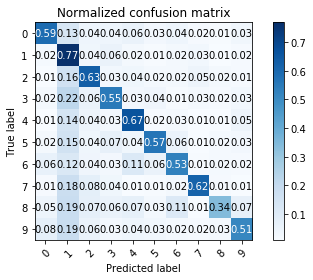

In [18]:
from sklearn.metrics import *
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
plot_confusion_matrix(y_test, preds, classes=np.arange(10), normalize=True,
                      title='Normalized confusion matrix')
plt.show()